In [2]:
import numpy as np
import matplotlib.pyplot as plt
from medpy import io
from radiomics import featureextractor, imageoperations
import six
import os
import pandas as pd
import SimpleITK as sitk
import seaborn as sns
from sklearn.metrics import roc_auc_score
import math

/u/home/seel/.conda/envs/conda-adlm/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from data_scripts.PI_CAI_Detection import PI_CAI_Detection
from src.models.augmentations import *
from radiomics_util import plot_sitk, resample_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
gt = pd.read_csv("/data1/practical-sose23/morphometric/picai_labels/clinical_information/marksheet.csv")
gt

patient_id  study_id    mri_date  patient_age    psa  psad  \
0          10000   1000000  2019-07-02           73   7.70   NaN   
1          10001   1000001  2016-05-27           64   8.70  0.09   
2          10002   1000002  2021-04-18           58   4.20  0.06   
3          10003   1000003  2019-04-05           72  13.00   NaN   
4          10004   1000004  2020-10-21           67   8.00  0.10   
...          ...       ...         ...          ...    ...   ...   
1493       11470   1001494  2018-09-22           60   9.10   NaN   
1494       11471   1001495  2012-08-25           71  12.50  0.21   
1495       11472   1001496  2019-06-28           81   5.28  0.12   
1496       11473   1001497  2017-09-24           56  29.60  0.34   
1497       11474   1001498  2016-05-03           71  12.00   NaN   

      prostate_volume histopath_type    lesion_GS lesion_ISUP  case_ISUP  \
0                55.0           MRBx          0+0           0          0   
1               102.0            NaN          NaN         NaN          0   
2                74.0            NaN          NaN         NaN          0   
3                71.5          SysBx          0+0           0          0   
4                78.0     SysBx+MRBx      0+0,0+0         0,0          0   
...               ...            ...          ...         ...        ...   
1493             47.0           MRBx      0+0,0+0         0,0          0   
1494             62.0           MRBx  3+4,N/A,3+3         2,1          2   
1495             44.0     SysBx+MRBx          3+4           2          2   
1496             87.0           MRBx          0+0           0          0   
1497             83.0           MRBx          3+3           1          1   

     case_csPCa  
0            NO  
1            NO  
2            NO  
3            NO  
4            NO  
...         ...  
1493         NO  
1494        YES  
1495        YES  
1496         NO  
1497         NO  

[1498 rows x 12 columns]

In [4]:
filter = gt[gt["case_csPCa"]=="YES"]
filter

patient_id  study_id    mri_date  patient_age    psa  psad  \
5          10005   1000005  2012-07-18           64  12.10  0.24   
8          10008   1000008  2020-12-06           81  11.10  0.20   
12         10012   1000012  2012-08-02           64   9.90  0.14   
13         10013   1000013  2018-11-21           64   4.50  0.10   
19         10019   1000019  2012-12-15           61  10.00  0.24   
...          ...       ...         ...          ...    ...   ...   
1485       11462   1001486  2012-05-06           64   9.07  0.16   
1488       11465   1001489  2016-10-28           65   6.40   NaN   
1491       11468   1001492  2020-11-07           64   4.30  0.20   
1494       11471   1001495  2012-08-25           71  12.50  0.21   
1495       11472   1001496  2019-06-28           81   5.28  0.12   

      prostate_volume histopath_type        lesion_GS lesion_ISUP  case_ISUP  \
5                51.0           MRBx          4+3,0+0         3,0          3   
8                56.0     SysBx+MRBx          4+3,3+4         3,2          3   
12               70.0           MRBx              3+4           2          2   
13               52.0             RP              3+4           2          2   
19               42.0           MRBx  N/A,N/A,N/A,3+4           2          2   
...               ...            ...              ...         ...        ...   
1485             58.0           MRBx          4+5,N/A           5          5   
1488             50.0             RP              3+4           2          2   
1491             23.0     SysBx+MRBx              4+3           3          3   
1494             62.0           MRBx      3+4,N/A,3+3         2,1          2   
1495             44.0     SysBx+MRBx              3+4           2          2   

     case_csPCa  
5           YES  
8           YES  
12          YES  
13          YES  
19          YES  
...         ...  
1485        YES  
1488        YES  
1491        YES  
1494        YES  
1495        YES  

[423 rows x 12 columns]

In [13]:
data_path = "/data1/practical-sose23/morphometric/data/"
seg_guer_path = "/data1/practical-sose23/morphometric/picai_labels/anatomical_delineations/whole_gland/AI/Guerbet23/"
seg_pca_path = "/data1/practical-sose23/morphometric/picai_labels/csPCa_lesion_delineations/human_expert/resampled/"

def get_image_and_segmentaion(patient_id, study_id, modality = "t2w"):
    if not isinstance(patient_id, str):
        patient_id = str(patient_id)

    if not isinstance(study_id, str):
        study_id = str(study_id)

    
    d_path = data_path
    s_path = seg_guer_path
    c_path = seg_pca_path
    
    image = None
    segmentation = None
    for file in os.listdir(d_path + patient_id + "/"):
        string = "{0}_{1}_{2}.mha".format(patient_id,study_id,modality)
        if string == file:
            if study_id in file:
                image = sitk.ReadImage(d_path + patient_id + "/" +  file, sitk.sitkFloat32)
                

    for file in os.listdir(s_path):
        if modality == "t2w" and patient_id+"_"+study_id + ".nii.gz" == file:
            
            segmentation = sitk.ReadImage(s_path + file, sitk.sitkUInt8)

        if modality == "adc" and patient_id+"_"+study_id + ".nii.gz" == file:
            
            segmentation = sitk.ReadImage(s_path + file, sitk.sitkUInt8)

    cancer = None
    for file in os.listdir(c_path):
        if modality == "t2w" and patient_id+"_"+study_id + ".nii.gz" == file:
            
            cancer = sitk.ReadImage(c_path + file, sitk.sitkUInt8)

        if modality == "adc" and patient_id+"_"+study_id + ".nii.gz" == file:
            
            cancer = sitk.ReadImage(c_path + file, sitk.sitkUInt8)

    return (image, segmentation, cancer)

def safe_image_mask(base_path, row, image, mask, modality = "t2w", suffix=""):

    file = "{0}_{1}_{2}_{3}.mha".format(str(int(row["patient_id"])),str(int(row["study_id"])), modality, suffix)

    writer = sitk.ImageFileWriter()
    writer.SetFileName(base_path +  file)
    writer.Execute(image)

    file = "{0}_{1}_{2}.nii.gz".format(str(int(row["patient_id"])),str(int(row["study_id"])), suffix)
    writer = sitk.ImageFileWriter()
    writer.SetFileName(base_path + file)
    writer.Execute(mask)

In [11]:
path = "/data1/practical-sose23/morphometric/resample_options/"

10005
10012


10019


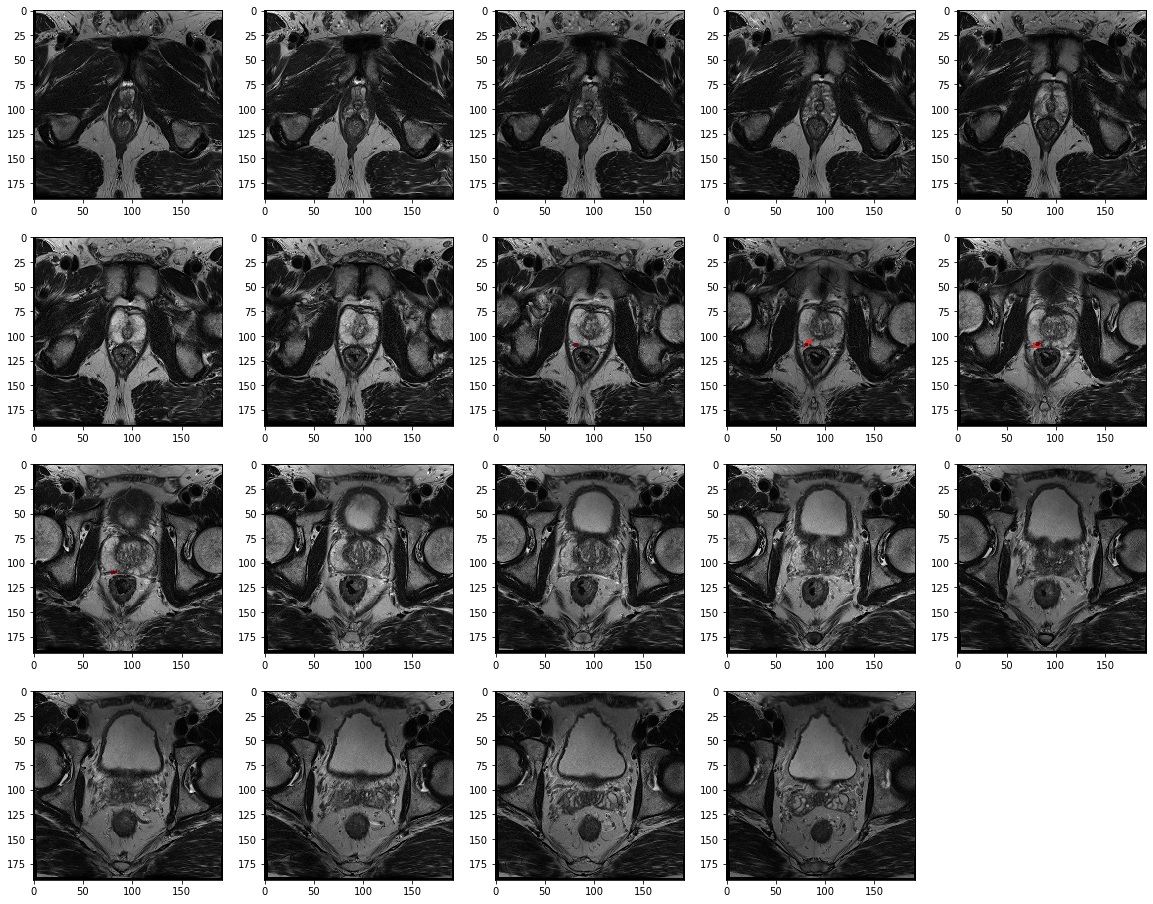

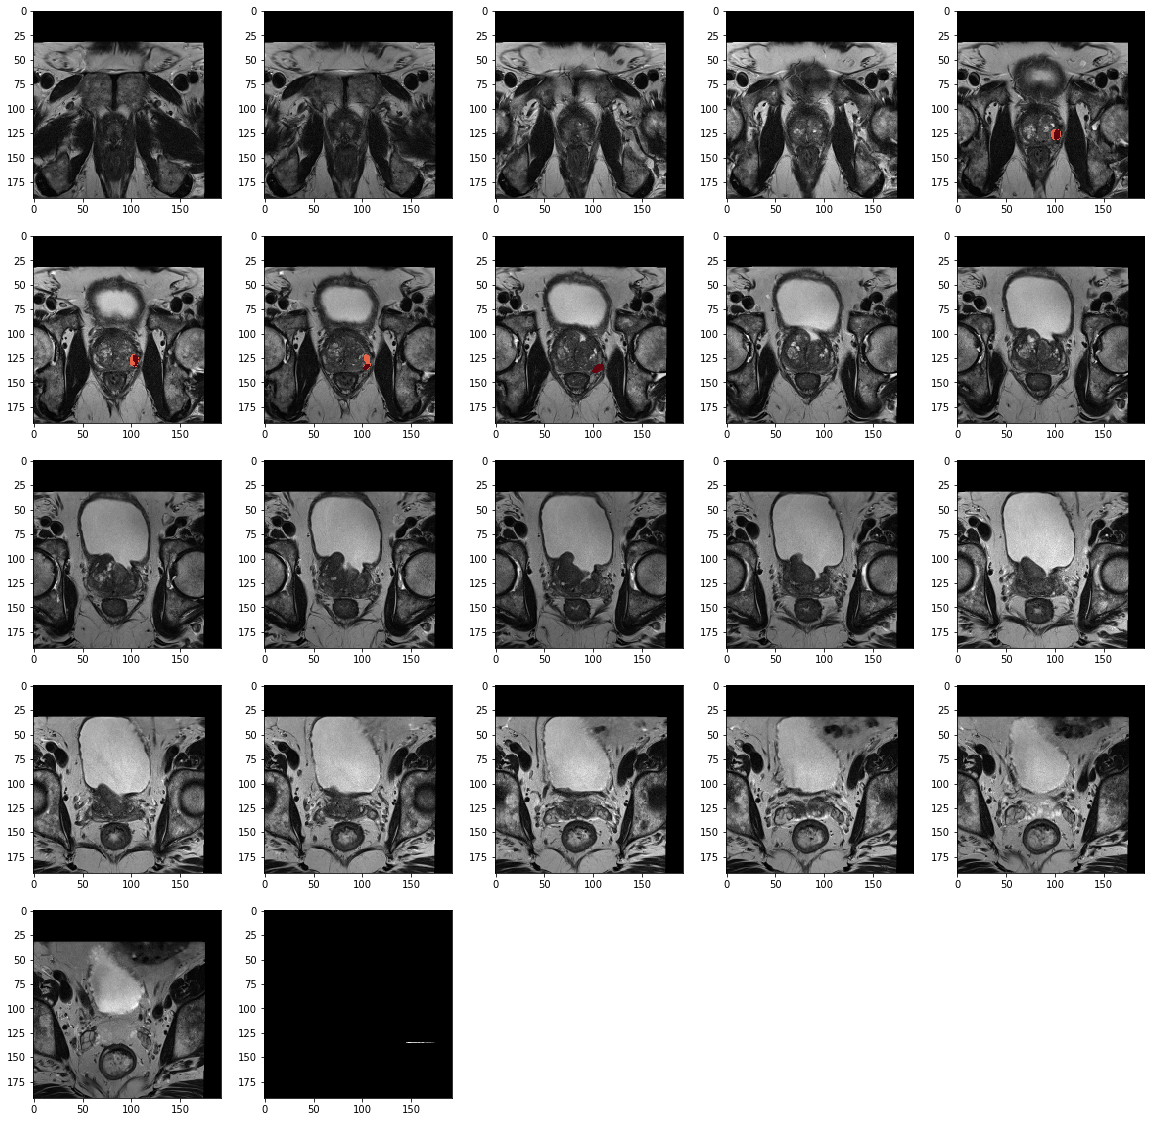

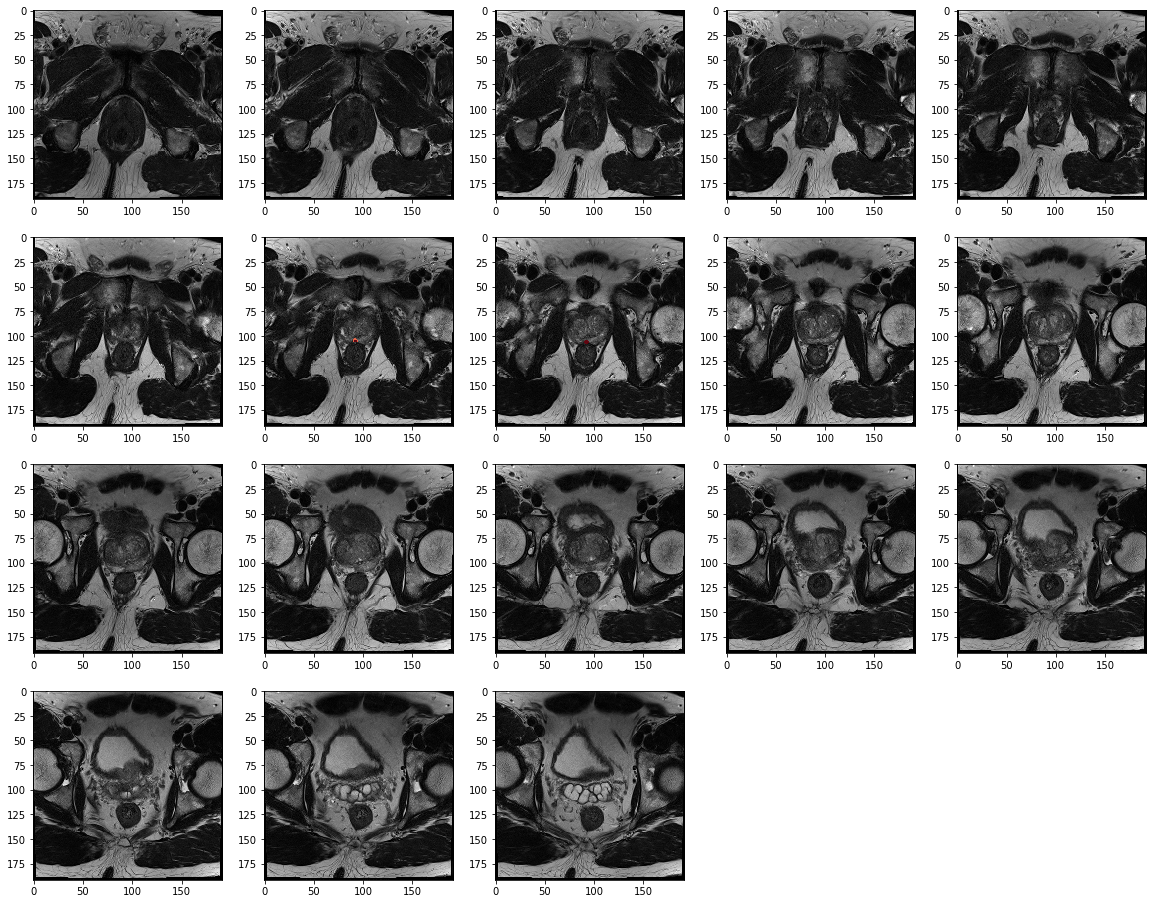

In [16]:
for i,row in filter.head(5).iterrows():
    image, prostate, cancer = get_image_and_segmentaion(patient_id=row["patient_id"], study_id=row["study_id"])
    
    if cancer is not None:
        print(row["patient_id"])
        #safe_image_mask(path, row, image, cancer, suffix="orig")
        c_i, c_r = resample_image(image, cancer, (1,1,3))
        plot_sitk(c_i,c_r)
        #safe_image_mask(path, row, c_i, c_r, suffix="1-1-3")
        c_i, c_r = resample_image(image, cancer, (1.5,1.5,3))
        #safe_image_mask(path, row, c_i, c_r, suffix="15-15-3")
        c_i, c_r = resample_image(image, cancer, (2,2,6))
        #safe_image_mask(path, row, c_i, c_r, suffix="2-2-6")
        
        

In [21]:
path ="/data1/practical-sose23/morphometric/resample_options/10019_1000019"

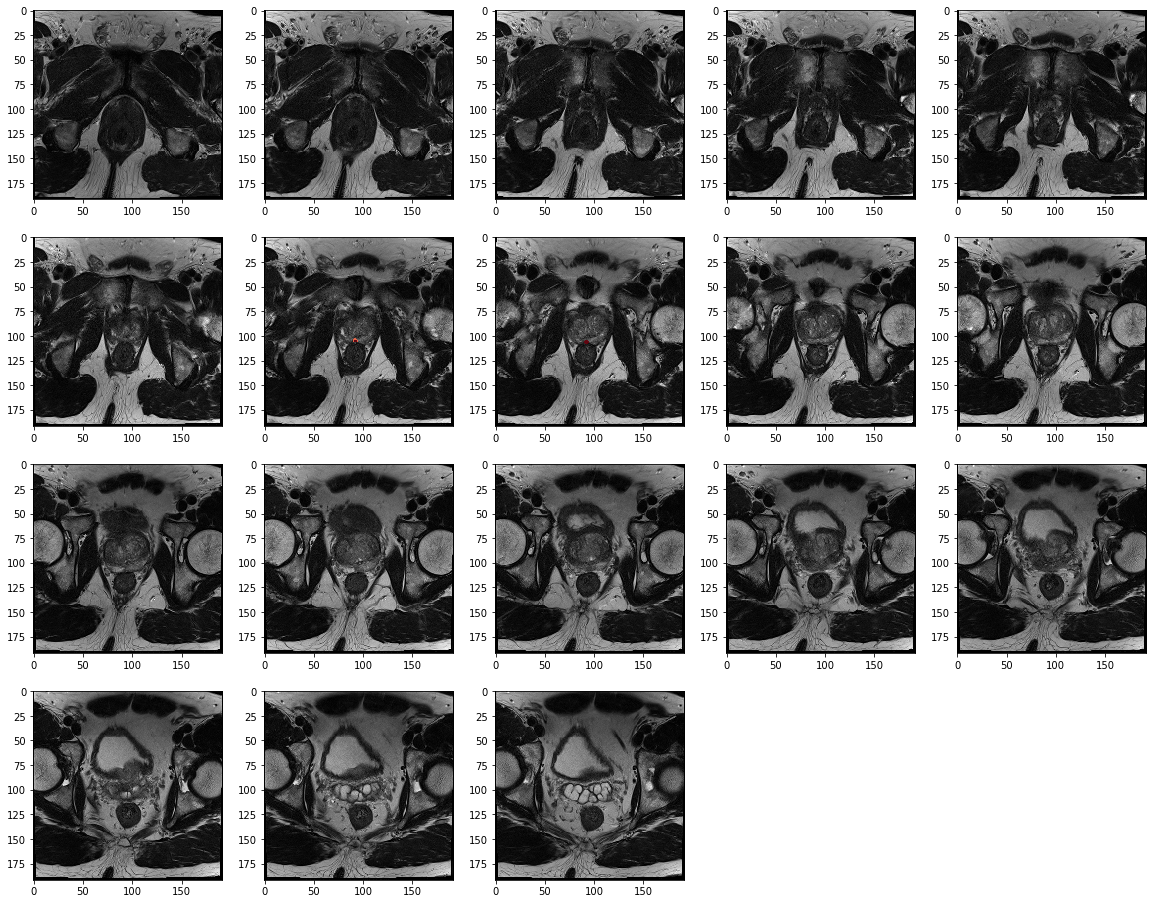

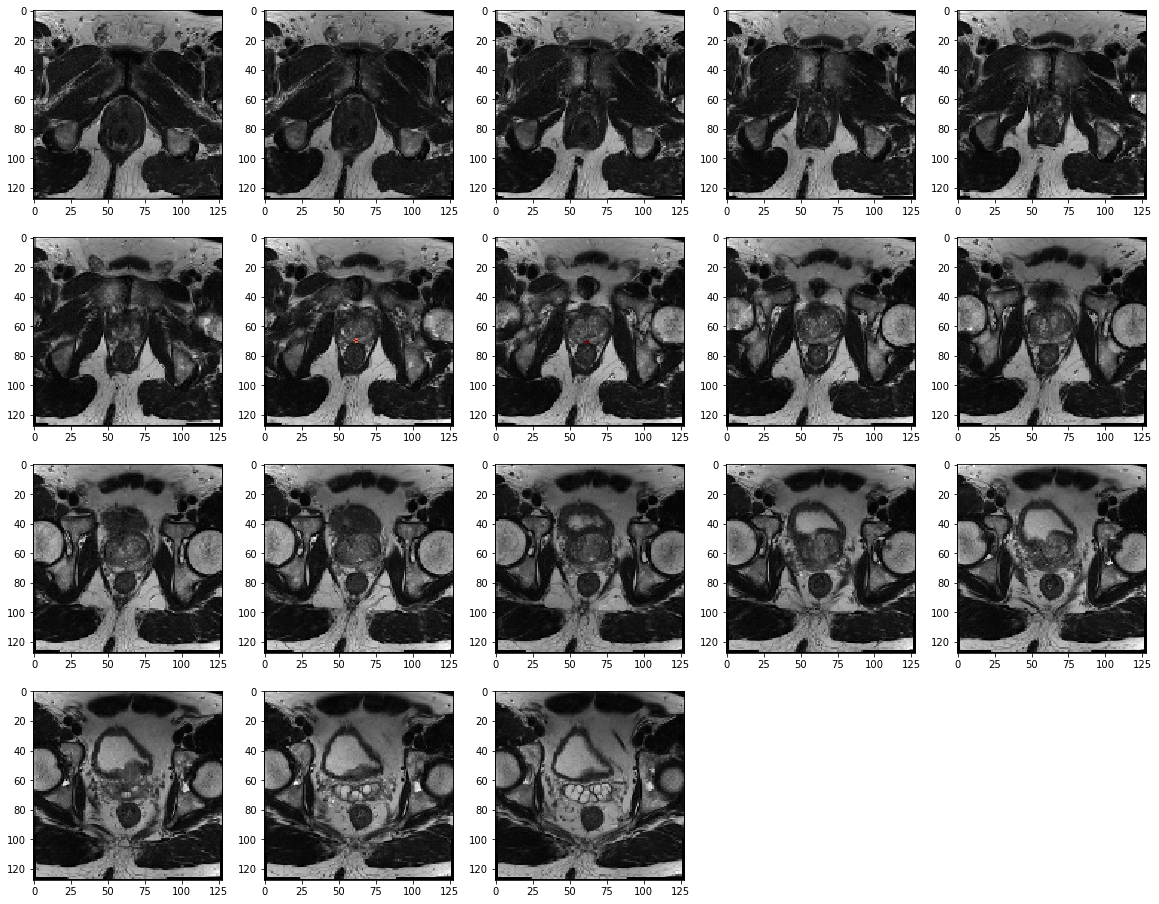

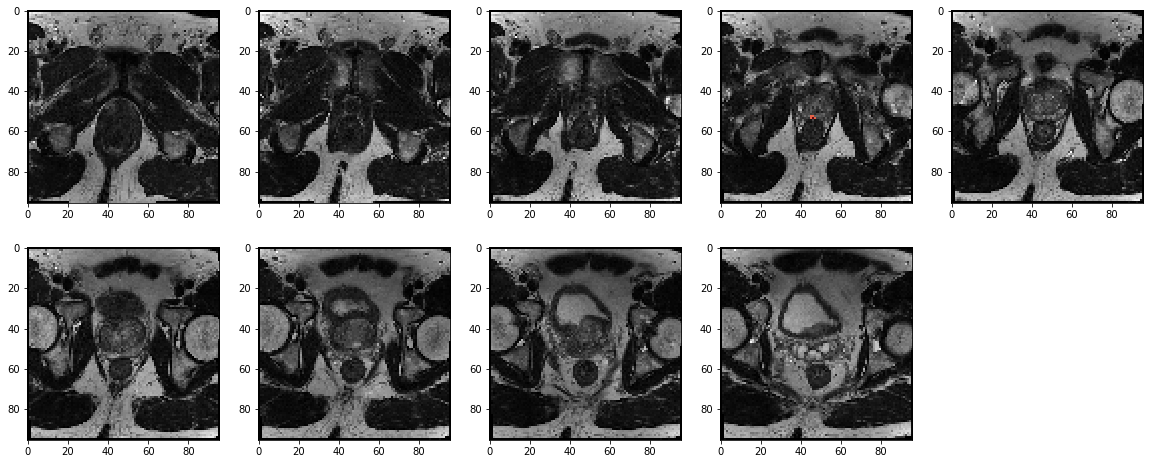

In [22]:
image = sitk.ReadImage(path + "_t2w"+ "_1-1-3" + ".mha", sitk.sitkFloat32)
mask = sitk.ReadImage(path + "_1-1-3" + ".nii.gz", sitk.sitkFloat32)
plot_sitk(image, mask)

image = sitk.ReadImage(path + "_t2w"+ "_15-15-3" + ".mha", sitk.sitkFloat32)
mask = sitk.ReadImage(path + "_15-15-3" + ".nii.gz", sitk.sitkFloat32)
plot_sitk(image, mask)

image = sitk.ReadImage(path + "_t2w"+ "_2-2-6" + ".mha", sitk.sitkFloat32)
mask = sitk.ReadImage(path + "_2-2-6" + ".nii.gz", sitk.sitkFloat32)
plot_sitk(image, mask)

In [4]:
df = pd.DataFrame([])

for index, row in gt.iterrows():
    if isinstance(row['prostate_volume'], float):
        print(str(index), end= "\r")

        image, mask = get_image_and_segmentaion(row["patient_id"], row["study_id"])

        
        new_row = {"study_id": row["study_id"], 
                   "patient_id": row["patient_id"],
                   "size_image" : image.GetSize(),
                   "size_mask" : mask.GetSize(),
        }
        df = df.append(new_row, ignore_index=True)

df

study_id  patient_id      size_image       size_mask
0     1000000.0     10000.0  (100, 100, 25)  (100, 100, 25)
1     1000001.0     10001.0  (100, 100, 25)  (100, 100, 25)
2     1000002.0     10002.0  (100, 100, 25)  (100, 100, 25)
3     1000003.0     10003.0  (100, 100, 25)  (100, 100, 25)
4     1000004.0     10004.0  (100, 100, 25)  (100, 100, 25)
...         ...         ...             ...             ...
1493  1001494.0     11470.0  (100, 100, 25)  (100, 100, 25)
1494  1001495.0     11471.0  (100, 100, 25)  (100, 100, 25)
1495  1001496.0     11472.0  (100, 100, 25)  (100, 100, 25)
1496  1001497.0     11473.0  (100, 100, 25)  (100, 100, 25)
1497  1001498.0     11474.0  (100, 100, 25)  (100, 100, 25)

[1498 rows x 4 columns]

In [38]:
df[df["size_image"] != df["size_mask"]]

Empty DataFrame
Columns: [study_id, patient_id, size_image, size_mask]
Index: []